# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from glob import glob
from keras import backend as K
from keras.preprocessing import image  
from keras.utils import np_utils
from tqdm import tqdm
from sklearn.datasets import load_files


%matplotlib inline     

In [22]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# img info
img_width = 224
img_height = 224
channels = 3

# dog labels
num_classes = 133

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# saved class labels for later use
if not os.path.exists('labels.txt'):
    np.savetxt('labels.txt', dog_names, delimiter=',', fmt='%s')

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


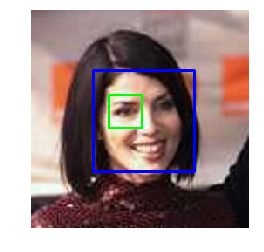

In [5]:
import cv2                                          

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

# load color (BGR) image
img = cv2.imread(human_files[8112])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    
    # find eyes on face
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.axis("off")
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [19]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

h_deteced_human = np.mean([face_detector(img) for img in human_files_short])
h_deteced_dog = np.mean([face_detector(img) for img in dog_files_short])

print("% of human faces detected\n{:.2f}% in human images\n".format(h_deteced_human * 100),
     "{:.2f}% in dog images".format(h_deteced_dog * 100))

% of human faces detected
100.00% in human images
 11.00% in dog images


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

In our use case, it's inappropriate to limit human detection only to a face view. Alternatively we could relax our constraint from a frontal face view to a profile face view(e.g. classifier only needs part of the face to detect). Or we might find a way to combine several classifiers(frontal face, profile face, eyes, and upper body). However, face detection appears to be the best to detect humans since the classifier can rely on many more features found in the face as opposed to a silhouette or pose of the body.

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [14]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [23]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [19]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
d_deteced_human = np.mean([dog_detector(img) for img in human_files_short])
d_deteced_dog = np.mean([dog_detector(img) for img in dog_files_short])

print("% of dogs detected:\n\t{:.2f}% in human images\n".format(d_deteced_human * 100),
     "\t{:.2f}% in dog images".format(d_deteced_dog * 100))

% of dogs detected:
	1.00% in human images
 	100.00% in dog images


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [24]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:04<00:00, 190.80it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

#### Overview of CNN architecture

##### [ 6 x Conv2D_maxpooling ] -> [ GAP ] -> [ FC ] -> [ Dropout ] -> [ Output - FC ]
> Conv2D_maxpooling = [ conv layer -> pooling layer ]

- pattern architecutre - one convolutional layer followed by a pooling layer, repeated 3 times
    - receptive field size(kernel size) 5x5 since we have a larger image
    - stride width of 1 and padding of zeros
- Use small kernel to gather a lot of information
- The beginning layers will be used to extract low level features
- Several layers will help identify complex structures on the dog
- Increase depth layer after layer to match increased complexity of model
- Use pooling to decrease dimensionality of feature map
- Connect to FC layers


In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

#### Augment Data

In [13]:
train_datagen = ImageDataGenerator(\
                            shear_range=0.2,
                            zoom_range=0.2,
                            rotation_range=40,
                            horizontal_flip=True)

train_datagen.fit(train_tensors)

val_datagen = ImageDataGenerator(\
                            shear_range=0.2,
                            zoom_range=0.2,
                            rotation_range=40,
                            horizontal_flip=True)

val_datagen.fit(valid_tensors)

#### Model Hyperparameters

In [14]:
ksize = (5,5)
psize = (2,2)
strides = 1
pad = 'SAME'
epochs = 70
batch_size = 20

#### Build Network

In [13]:
model = Sequential()

# Conv Layer 1
model.add(
    Conv2D(filters=16, kernel_size=ksize, padding=pad,
           strides=strides, input_shape=(224, 224, 3), activation='relu')
)
model.add(MaxPooling2D(pool_size=psize, padding=pad))

# Conv Layer 2
model.add(
    Conv2D(filters=16, kernel_size=ksize, padding=pad, strides=strides,
           activation='relu')
)
model.add(MaxPooling2D(pool_size=psize, padding=pad))

# Conv Layer 3
model.add(
    Conv2D(filters=32, kernel_size=ksize, padding=pad, strides=strides,
           activation='relu')
)
model.add(MaxPooling2D(pool_size=psize, padding=pad))

# Conv Layer 4
model.add(
    Conv2D(filters=32, kernel_size=ksize, padding=pad, strides=strides,
           activation='relu')
)
model.add(MaxPooling2D(pool_size=psize, padding=pad))

# Conv Layer 5
model.add(
    Conv2D(filters=64, kernel_size=ksize, padding=pad, strides=strides,
           activation='relu')
)
model.add(MaxPooling2D(pool_size=psize, padding=pad))

# Conv Layer 6
model.add(
    Conv2D(filters=64, kernel_size=ksize, padding=pad, strides=strides,
           activation='relu')
)
model.add(MaxPooling2D(pool_size=psize, padding=pad))

# GAP - Flatten
model.add(GlobalAveragePooling2D())

# Dense Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(.2))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      6416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        12832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        25632     
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [23]:
callbacks_list = [
    ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, monitor='val_acc', save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0)
]

train_hist = model.fit_generator(\
                                 train_datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                                 validation_data=val_datagen.flow(valid_tensors, valid_targets),
                                 validation_steps= 835 // batch_size,
                                 steps_per_epoch= 6680 // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks_list, verbose=2)

Epoch 1/70
Epoch 00000: val_acc improved from -inf to 0.01013, saving model to saved_models/weights.best.from_scratch.hdf5
42s - loss: 4.8864 - acc: 0.0079 - val_loss: 4.8715 - val_acc: 0.0101
Epoch 2/70
Epoch 00001: val_acc did not improve
41s - loss: 4.8736 - acc: 0.0109 - val_loss: 4.8691 - val_acc: 0.0080
Epoch 3/70
Epoch 00002: val_acc improved from 0.01013 to 0.01091, saving model to saved_models/weights.best.from_scratch.hdf5
40s - loss: 4.8704 - acc: 0.0106 - val_loss: 4.8667 - val_acc: 0.0109
Epoch 4/70
Epoch 00003: val_acc improved from 0.01091 to 0.01515, saving model to saved_models/weights.best.from_scratch.hdf5
38s - loss: 4.8689 - acc: 0.0124 - val_loss: 4.8602 - val_acc: 0.0152
Epoch 5/70
Epoch 00004: val_acc improved from 0.01515 to 0.02182, saving model to saved_models/weights.best.from_scratch.hdf5
39s - loss: 4.8235 - acc: 0.0150 - val_loss: 4.7783 - val_acc: 0.0218
Epoch 6/70
Epoch 00005: val_acc did not improve
39s - loss: 4.7442 - acc: 0.0174 - val_loss: 4.6857 -

#### Analyze Learning Curves

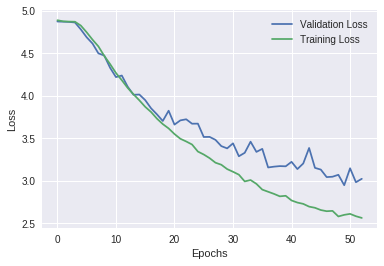

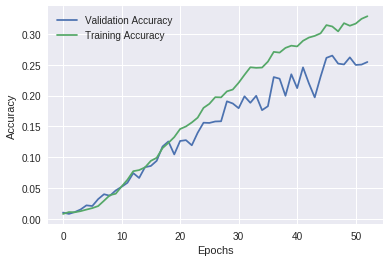

In [24]:
# Grab number of epochs actually trained for
epochs_ = len(train_hist.history['val_acc'])

# Plot learning curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(epochs_), train_hist.history['val_loss'], label='Validation Loss')
plt.plot(range(epochs_), train_hist.history['loss'], label='Training Loss')
plt.legend(loc="best")

# Plot accuracy curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(epochs_), train_hist.history['val_acc'], label='Validation Accuracy')
plt.plot(range(epochs_), train_hist.history['acc'], label='Training Accuracy')
plt.legend(loc="best")

### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [26]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 31.5789%


#### Visualize layers

In [133]:
# CODE FROM https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py

def deprocess_image(x):
    # normalize tensor
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0 , 255).astype('uint8')
    return x

def normalize(x):
    # L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def get_filter_viz(model, layer_name, num_filters, img_width=224, img_height=224, save=False):
    # this is the placeholder for the input images
    input_img = model.input
    layer_dict = dict([layer.name, layer] for layer in model.layers)
    
    kept_filters = []
    for filter_index in range(0, num_filters):   
        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output

        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # compute gradient of the input pictures wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalize
        grads = normalize(grads)

        # fn returns loss and grds given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # run gradient ascent
        for _ in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

            # decode the resulting input image
            if loss_value > 0:
                img = deprocess_image(input_img_data[0])
                kept_filters.append((img, loss_value))

    # we will stich the best 16 filters on a 4 x 4 grid.
    n = int(np.sqrt(num_filters))

    # the filters that have the highest loss are assumed to be better-looking.
    # we will only keep the top 64 filters.
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]

    # build a black picture with enough space for
    # our 4 x 4 filters of size 224 x 224, with a 5px margin in between
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

    if save:
        if not os.path.exists('filter_images'):
            os.mkdir('filter_images')

        # save the result to disk
        plt.imsave('filter_images/stitched_filters_%s_%dx%d.png' % (layer_name, n, n), stitched_filters)
    else:
        plt.axis("off")
        imgplot = plt.imshow(stitched_filters)
        plt.show()

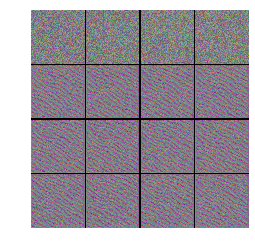

In [134]:
layer_name = 'conv2d_20'
num_filters = 16
get_filter_viz(model, layer_name, num_filters)

#### Layer 1 - filter visualizations

![conv2d_19](filter_images/stitched_filters_conv2d_19_4x4.png)

#### Layer 4 - filter visualizations

![conv2d_22](filter_images/stitched_filters_conv2d_22_5x5.png)

#### Layer 6 - filter visualizations

![conv2d_24](filter_images/stitched_filters_conv2d_24_8x8.png)

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(num_classes, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=0, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
1s - loss: 12.7768 - acc: 0.1123 - val_loss: 11.3516 - val_acc: 0.2084
Epoch 2/20
1s - loss: 10.8321 - acc: 0.2527 - val_loss: 10.9192 - val_acc: 0.2383
Epoch 3/20
1s - loss: 10.3549 - acc: 0.3048 - val_loss: 10.5197 - val_acc: 0.2850
Epoch 4/20
1s - loss: 10.1218 - acc: 0.3320 - val_loss: 10.4628 - val_acc: 0.2958
Epoch 5/20
1s - loss: 10.0104 - acc: 0.3494 - val_loss: 10.3873 - val_acc: 0.3018
Epoch 6/20
1s - loss: 9.9428 - acc: 0.3609 - val_loss: 10.3529 - val_acc: 0.3126
Epoch 7/20
1s - loss: 9.8114 - acc: 0.3702 - val_loss: 10.1698 - val_acc: 0.3198
Epoch 8/20
1s - loss: 9.6753 - acc: 0.3832 - val_loss: 10.1413 - val_acc: 0.3281
Epoch 9/20
1s - loss: 9.6146 - acc: 0.3912 - val_loss: 10.1281 - val_acc: 0.3198
Epoch 10/20
1s - loss: 9.5781 - acc: 0.3987 - val_loss: 10.0591 - val_acc: 0.3353
Epoch 11/20
1s - loss: 9.5640 - acc: 0.3976 - val_loss: 10.0879 - val_acc: 0.3305
Epoch 12/20
1s - loss: 9.5160 - acc: 0.4016 - val_loss:

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 38.6364%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [4]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

#### Overview of Transfer learning model with Resnet

__Answer:__ 

Architecture emerged out of experimentation.

- I experimented with different number of units for the dense layer after getting inputs from the Resnet.
- Afterwards I applied a dropout to help alleviate some of the overfitting.
- Use small batch size(8) for more noise

I also compared the Resnet50 model to an Inception V3 model:
- Both models employ a "network within a network" architectures using different micro-architectures:
    - Both architectures are network within a network because they define micro-architectures(i.e. 'building blocks') that are essentially repeated to build deep networks
    - Resnet architecture mimics the VGG architecture but much deeper. Before going deeper was not viable but with the introduction of a residual module features remain trainable at much larger depths. A residual module ensures that adding a new layer onto a module benefits the network by allowing the layer to learn something new. 
    - Inception architecutre introduced the inception module. Instead of using common convolutions to learn linear functions of the inputs, an inception module is a multi-level feature extractor which uses multiple convolutions in the same module/input then concatenates them as the output.
- The inception model has much more params than the Resnet50 because of the inception module. However it takes up less space than the Resnet model. Further, because of the inception module the architecture appears to have added more complexity without giving up much more training time.
    
The Resnet50 model may out perform the Inception v3 model but that may only be for this task. It may be that the Resnet model is more tuned to pick up dog-like features. In addition, I chose inception layer 292 but it may be that an earlier layer is more tuned to dog-like features.

In [5]:
d_Resnet50_model = Sequential()

# Get top layer of Resnet50 - Flatten
d_Resnet50_model.add(Flatten(input_shape=train_Resnet50.shape[1:]))
# Use Fully connected layer
d_Resnet50_model.add(Dense(256, activation='relu'))
# Dropout to reduce overfitting
d_Resnet50_model.add(Dropout(.4))
# Fully connected layer for output
d_Resnet50_model.add(Dense(num_classes, activation='softmax'))

d_Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [6]:
d_Resnet50_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

#### Hyperparameters

In [211]:
epochs = 50
batch_size = 8

In [212]:
callbacks_list = [
    ModelCheckpoint(filepath='saved_models/weights.best.dResnet50.hdf5', 
                               verbose=1, monitor='val_acc', save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=10, verbose=0)
]

train_hist = d_Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
Epoch 00000: val_acc improved from -inf to 0.67425, saving model to saved_models/weights.best.dResnet50.hdf5
14s - loss: 3.0639 - acc: 0.3144 - val_loss: 1.3396 - val_acc: 0.6743
Epoch 2/50
Epoch 00001: val_acc improved from 0.67425 to 0.75329, saving model to saved_models/weights.best.dResnet50.hdf5
9s - loss: 1.3505 - acc: 0.6238 - val_loss: 0.8873 - val_acc: 0.7533
Epoch 3/50
Epoch 00002: val_acc improved from 0.75329 to 0.78563, saving model to saved_models/weights.best.dResnet50.hdf5
9s - loss: 0.9295 - acc: 0.7263 - val_loss: 0.7388 - val_acc: 0.7856
Epoch 4/50
Epoch 00003: val_acc improved from 0.78563 to 0.80120, saving model to saved_models/weights.best.dResnet50.hdf5
9s - loss: 0.7102 - acc: 0.7835 - val_loss: 0.6359 - val_acc: 0.8012
Epoch 5/50
Epoch 00004: val_acc improved from 0.80120 to 0.80719, saving model to saved_models/weights.best.dResnet50.hdf5
9s - loss: 0.5831 - acc: 0.8174 - val_loss: 0.6175 - val_acc: 0.

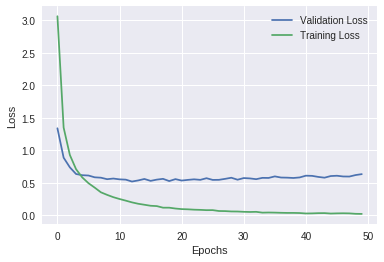

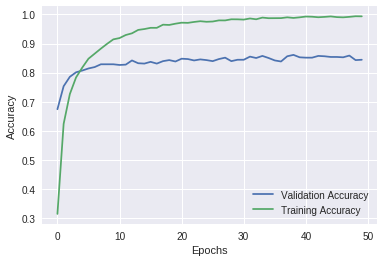

In [213]:
epochs_ = len(train_hist.history['val_acc'])

# Plot learning curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(epochs_), train_hist.history['val_loss'], label='Validation Loss')
plt.plot(range(epochs_), train_hist.history['loss'], label='Training Loss')
plt.legend(loc="best")

# Plot accuracy curve
plt.figure()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(epochs_), train_hist.history['val_acc'], label='Validation Accuracy')
plt.plot(range(epochs_), train_hist.history['acc'], label='Training Accuracy')
plt.legend(loc="best")

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [7]:
d_Resnet50_model.load_weights('saved_models/weights.best.dResnet50.hdf5')

In [9]:
# serialize model to JSON
model_json = d_Resnet50_model.to_json()
with open("saved_models/model.dResnet50.json", "w") as json_file:
    json_file.write(model_json)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [17]:
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(d_Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.3301%


In [48]:
from extract_bottleneck_features import *

def Resnet50_predict_top3_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = d_Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    top_3 = np.argsort(predicted_vector[0])[::-1][:3]
    return [dog_names[index] for index in top_3]

In [51]:
num_compare = 10

for _ in range(num_compare):
    index = random.randint(0, len(test_files))
    path = test_files[index]
    target = test_targets[index]
    actual = dog_names[np.argmax(target)]
    predictions = Resnet50_predict_top3_breed(path)
    print("Actual: {}\tTop 3: {}".format(actual, predictions))

Actual: Miniature_schnauzer	Top 3: ['Miniature_schnauzer', 'Lowchen', 'Chinese_crested']
Actual: Bichon_frise	Top 3: ['Bichon_frise', 'Havanese', 'Maltese']
Actual: French_bulldog	Top 3: ['French_bulldog', 'Boston_terrier', 'Bulldog']
Actual: Australian_cattle_dog	Top 3: ['Australian_cattle_dog', 'Bluetick_coonhound', 'German_wirehaired_pointer']
Actual: Canaan_dog	Top 3: ['Canaan_dog', 'Finnish_spitz', 'Labrador_retriever']
Actual: Japanese_chin	Top 3: ['Japanese_chin', 'Papillon', 'Pekingese']
Actual: Irish_wolfhound	Top 3: ['Glen_of_imaal_terrier', 'Irish_wolfhound', 'Old_english_sheepdog']
Actual: Basset_hound	Top 3: ['American_foxhound', 'Basset_hound', 'Dachshund']
Actual: English_toy_spaniel	Top 3: ['English_toy_spaniel', 'Cavalier_king_charles_spaniel', 'Gordon_setter']
Actual: French_bulldog	Top 3: ['French_bulldog', 'Bulldog', 'Boston_terrier']


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [18]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = d_Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

### Inception V3 Implementation

#### Hyperparams

In [43]:
batch_size = 32
epochs = 50
transformation_ratio = .05
rotation_range = 40

#### Build Model

In [44]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_width, img_height, channels))

# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Add top layer to base model
inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

# Train top layers and freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

print(inceptionv3_model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_189 (Conv2D)              (None, 111, 111, 32)  864         input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_189 (BatchNo (None, 111, 111, 32)  96          conv2d_189[0][0]                 
____________________________________________________________________________________________________
activation_189 (Activation)      (None, 111, 111, 32)  0           batch_normalization_189[0][0]    
___________________________________________________________________________________________

In [32]:
total_num_layers = len(inceptionv3_model.layers)
print("Model has {} layers".format(total_num_layers))
print("\nLast 10 Layers:")
last_ten_layers = inceptionv3_model.layers[-200:]
last_ten_layers.reverse()
for i, layer in enumerate(last_ten_layers):
    print("\t{}  {}".format(total_num_layers -i, layer.name))

Model has 314 layers

Last 10 Layers:
	314  dense_6
	313  dense_5
	312  global_average_pooling2d_2
	311  mixed10
	310  activation_143
	309  concatenate_2
	308  mixed9_1
	307  activation_135
	306  batch_normalization_94
	305  activation_142
	304  activation_141
	303  activation_138
	302  activation_137
	301  batch_normalization_86
	300  conv2d_100
	299  batch_normalization_93
	298  batch_normalization_92
	297  batch_normalization_89
	296  batch_normalization_88
	295  conv2d_92
	294  average_pooling2d_9
	293  conv2d_99
	292  conv2d_98
	291  conv2d_95
	290  conv2d_94
	289  activation_140
	288  activation_136
	287  batch_normalization_91
	286  batch_normalization_87
	285  conv2d_97
	284  conv2d_93
	283  activation_139
	282  batch_normalization_90
	281  conv2d_96
	280  mixed9
	279  activation_134
	278  concatenate_1
	277  mixed9_0
	276  activation_126
	275  batch_normalization_85
	274  activation_133
	273  activation_132
	272  activation_129
	271  activation_128
	270  batch_normalization_77

In [45]:
based_model_last_block_layer_number = 292

#### Data Augment

In [19]:
# Read data and augment it
train_datagen = ImageDataGenerator(\
                            shear_range=transformation_ratio,
                            zoom_range=transformation_ratio,
                            rotation_range=rotation_range,
                            horizontal_flip=True)

train_datagen.fit(train_tensors)

In [46]:
inceptionv3_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Save Weights

In [30]:
top_weights_path = os.path.join(os.path.abspath('saved_models'), 'inceptionv3.best.weights.h5')
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0)
]

#### Train Model

In [102]:
inceptionv3_model.fit_generator(\
                             train_datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                             validation_data = (valid_tensors, valid_targets),
                             steps_per_epoch= 6680 // batch_size,
                             epochs=epochs,
                             callbacks=callbacks_list, verbose=2)

Epoch 1/50
Epoch 00000: val_acc improved from -inf to 0.60479, saving model to /media/dreamsmith/First/Dev/MachineLearning/ai/repos/dog-project/saved_models/inceptionv3.best.weights.h5
161s - loss: 3.5918 - acc: 0.2405 - val_loss: 1.4722 - val_acc: 0.6048
Epoch 2/50
Epoch 00001: val_acc improved from 0.60479 to 0.63114, saving model to /media/dreamsmith/First/Dev/MachineLearning/ai/repos/dog-project/saved_models/inceptionv3.best.weights.h5
37s - loss: 2.1958 - acc: 0.4500 - val_loss: 1.3410 - val_acc: 0.6311
Epoch 3/50
Epoch 00002: val_acc improved from 0.63114 to 0.65030, saving model to /media/dreamsmith/First/Dev/MachineLearning/ai/repos/dog-project/saved_models/inceptionv3.best.weights.h5
37s - loss: 1.8418 - acc: 0.5099 - val_loss: 1.2760 - val_acc: 0.6503
Epoch 4/50
Epoch 00003: val_acc improved from 0.65030 to 0.65269, saving model to /media/dreamsmith/First/Dev/MachineLearning/ai/repos/dog-project/saved_models/inceptionv3.best.weights.h5
36s - loss: 1.6436 - acc: 0.5532 - val_l

#### Load Model

In [31]:
inceptionv3_model.load_weights(top_weights_path)

In [104]:
# get index of predicted dog breed for each image in test set
Inceptionv3_predictions = [np.argmax(inceptionv3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inceptionv3_predictions)==np.argmax(test_targets, axis=1))/len(Inceptionv3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 66.9856%


#### Fine Tune

In [47]:
learning_rate = 1e-3
momentum = 0.9

In [48]:
from keras.optimizers import SGD

for layer in inceptionv3_model.layers[:based_model_last_block_layer_number]:
    layer.trainable = False
for layer in inceptionv3_model.layers[based_model_last_block_layer_number:]:
    layer.trainable = True
    
# inceptionv3_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
inceptionv3_model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum),
                          loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# save weights of best training epoch: monitor either val_loss or val_acc
final_weights_path = os.path.join(os.path.abspath('saved_models'), 'inceptionv3.best.final.weights.h5')
callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=0),
    TensorBoard(log_dir='./Graph', histogram_freq=epochs, batch_size=batch_size,
           write_graph=True, write_images=True)
]

In [27]:
train_hist = inceptionv3_model.fit_generator(\
                                 train_datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                                validation_data = (valid_tensors, valid_targets),
                                 steps_per_epoch= 6680 // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks_list, verbose=2)

INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/beta:0 is illegal; using batch_normalization_1/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_mean:0 is illegal; using batch_normalization_1/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_1/moving_variance:0 is illegal; using batch_normalization_1/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_2/beta:0 is

INFO:tensorflow:Summary name batch_normalization_6/moving_variance:0 is illegal; using batch_normalization_6/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/beta:0 is illegal; using batch_normalization_8/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/beta:0 is illegal; using batch_normalization_8/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/moving_mean:0 is illegal; using batch_normalization_8/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/moving_mean:0 is illegal; using batch_normalization_8/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/moving_variance:0 is illegal; using batch_normalization_8/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_8/moving_variance:0 is illegal; using batch_normalization_8/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_11/beta:0 is illegal; using batch_normalization_11/beta_0 i

INFO:tensorflow:Summary name batch_normalization_19/moving_mean:0 is illegal; using batch_normalization_19/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_19/moving_mean:0 is illegal; using batch_normalization_19/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_19/moving_variance:0 is illegal; using batch_normalization_19/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_19/moving_variance:0 is illegal; using batch_normalization_19/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_23/kernel:0 is illegal; using conv2d_23/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_23/kernel:0 is illegal; using conv2d_23/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_23/beta:0 is illegal; using batch_normalization_23/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_23/beta:0 is illegal; using batch_normalization_23/beta_0 instead.
INFO:tensorflow:Summary name batch_normaliza

INFO:tensorflow:Summary name conv2d_31/kernel:0 is illegal; using conv2d_31/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_34/kernel:0 is illegal; using conv2d_34/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_34/kernel:0 is illegal; using conv2d_34/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_39/kernel:0 is illegal; using conv2d_39/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_39/kernel:0 is illegal; using conv2d_39/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_40/kernel:0 is illegal; using conv2d_40/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_40/kernel:0 is illegal; using conv2d_40/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_31/beta:0 is illegal; using batch_normalization_31/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_31/beta:0 is illegal; using batch_normalization_31/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_31/moving_mean:0 is illegal; using batch_normalization_31/mov

INFO:tensorflow:Summary name batch_normalization_43/moving_mean:0 is illegal; using batch_normalization_43/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_43/moving_variance:0 is illegal; using batch_normalization_43/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_43/moving_variance:0 is illegal; using batch_normalization_43/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_48/beta:0 is illegal; using batch_normalization_48/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_48/beta:0 is illegal; using batch_normalization_48/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_48/moving_mean:0 is illegal; using batch_normalization_48/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_48/moving_mean:0 is illegal; using batch_normalization_48/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_48/moving_variance:0 is illegal; using batch_normaliz

INFO:tensorflow:Summary name batch_normalization_57/moving_mean:0 is illegal; using batch_normalization_57/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_57/moving_mean:0 is illegal; using batch_normalization_57/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_57/moving_variance:0 is illegal; using batch_normalization_57/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_57/moving_variance:0 is illegal; using batch_normalization_57/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_53/kernel:0 is illegal; using conv2d_53/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_53/kernel:0 is illegal; using conv2d_53/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_58/kernel:0 is illegal; using conv2d_58/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_58/kernel:0 is illegal; using conv2d_58/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_53/beta:0 is illegal; using batch_norma

INFO:tensorflow:Summary name conv2d_62/kernel:0 is illegal; using conv2d_62/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_67/kernel:0 is illegal; using conv2d_67/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_67/kernel:0 is illegal; using conv2d_67/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_62/beta:0 is illegal; using batch_normalization_62/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_62/beta:0 is illegal; using batch_normalization_62/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_62/moving_mean:0 is illegal; using batch_normalization_62/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_62/moving_mean:0 is illegal; using batch_normalization_62/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_62/moving_variance:0 is illegal; using batch_normalization_62/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_62/moving_variance:0 is illegal; using 

INFO:tensorflow:Summary name batch_normalization_73/moving_variance:0 is illegal; using batch_normalization_73/moving_variance_0 instead.
INFO:tensorflow:Summary name batch_normalization_73/moving_variance:0 is illegal; using batch_normalization_73/moving_variance_0 instead.
INFO:tensorflow:Summary name conv2d_74/kernel:0 is illegal; using conv2d_74/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_74/kernel:0 is illegal; using conv2d_74/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_74/beta:0 is illegal; using batch_normalization_74/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_74/beta:0 is illegal; using batch_normalization_74/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_74/moving_mean:0 is illegal; using batch_normalization_74/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_74/moving_mean:0 is illegal; using batch_normalization_74/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normaliza

INFO:tensorflow:Summary name conv2d_84/kernel:0 is illegal; using conv2d_84/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_84/kernel:0 is illegal; using conv2d_84/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_77/kernel:0 is illegal; using conv2d_77/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_77/kernel:0 is illegal; using conv2d_77/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_79/beta:0 is illegal; using batch_normalization_79/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_79/beta:0 is illegal; using batch_normalization_79/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_79/moving_mean:0 is illegal; using batch_normalization_79/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_79/moving_mean:0 is illegal; using batch_normalization_79/moving_mean_0 instead.
INFO:tensorflow:Summary name batch_normalization_79/moving_variance:0 is illegal; using batch_normalization_79/moving_variance_0 ins

INFO:tensorflow:Summary name conv2d_89/kernel:0 is illegal; using conv2d_89/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_92/kernel:0 is illegal; using conv2d_92/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_92/kernel:0 is illegal; using conv2d_92/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_93/kernel:0 is illegal; using conv2d_93/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_93/kernel:0 is illegal; using conv2d_93/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_86/kernel:0 is illegal; using conv2d_86/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_86/kernel:0 is illegal; using conv2d_86/kernel_0 instead.
INFO:tensorflow:Summary name batch_normalization_88/beta:0 is illegal; using batch_normalization_88/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_88/beta:0 is illegal; using batch_normalization_88/beta_0 instead.
INFO:tensorflow:Summary name batch_normalization_88/moving_mean:0 is illegal; using batch_normalization_88/mov

Epoch 00013: val_acc improved from 0.73054 to 0.73174, saving model to /media/dreamsmith/First/Dev/MachineLearning/ai/repos/dog-project/saved_models/inceptionv3.best.final.weights.h5
34s - loss: 0.6256 - acc: 0.8094 - val_loss: 0.9642 - val_acc: 0.7317
Epoch 15/50
Epoch 00014: val_acc did not improve
34s - loss: 0.6128 - acc: 0.8154 - val_loss: 0.9715 - val_acc: 0.7305
Epoch 16/50
Epoch 00015: val_acc improved from 0.73174 to 0.73293, saving model to /media/dreamsmith/First/Dev/MachineLearning/ai/repos/dog-project/saved_models/inceptionv3.best.final.weights.h5
35s - loss: 0.6065 - acc: 0.8201 - val_loss: 0.9895 - val_acc: 0.7329
Epoch 17/50
Epoch 00016: val_acc did not improve
36s - loss: 0.5902 - acc: 0.8172 - val_loss: 0.9810 - val_acc: 0.7281


#### Save Model Architecture

In [51]:
# serialize model to JSON
model_json = inceptionv3_model.to_json()
with open("saved_models/model.inceptionv3.json", "w") as json_file:
    json_file.write(model_json)

In [50]:
inceptionv3_model.load_weights(final_weights_path)

In [52]:
# get index of predicted dog breed for each image in test set
Inceptionv3_predictions = [np.argmax(inceptionv3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

# report test accuracy
final_test_accuracy = 100*np.sum(np.array(Inceptionv3_predictions)==np.argmax(test_targets, axis=1))/len(Inceptionv3_predictions)
print('Test accuracy: %.4f%%' % final_test_accuracy)

Test accuracy: 73.2057%


In [112]:
print("Fine tuned model performance increase: {:.4f}%".format(final_test_accuracy - test_accuracy))

Fine tuned model performance increase: 8.2536%


In [59]:
from keras.applications.inception_v3 import preprocess_input

def InceptionV3_predict(img_path):
    input_tensor = preprocess_input(path_to_tensor(img_path))
    pred = inceptionv3_model.predict(input_tensor)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(pred)]

In [60]:
InceptionV3_predict('./images/Labrador_retriever_06457.jpg')

'Dalmatian'

### Resnet50 vs InceptionV3

In [28]:
def res_inc_predict(img_path, target):
    print()
    res_pred = Resnet50_predict_breed(img_path)
    inc_pred = InceptionV3_predict(img_path)
    actual = dog_names[np.argmax(target)]
    output = "Dog breed: {}\n\tResnet50: {}\n\tInceptionv3: {}".format(actual, res_pred, inc_pred)
    return output, int(res_pred == actual), int(inc_pred == actual)

In [35]:
num_compare = 5
res_corr = 0
inc_corr = 0

for _ in range(num_compare):
    index = random.randint(0, len(test_files))
    path = test_files[index]
    target = test_targets[index]
    msg, score_r, score_i = res_inc_predict(path, target)
    res_corr += score_r
    inc_corr += score_i
    print("{}\nScore: Resnet {}/{}\tInception {}/{}".format(
        msg,
        res_corr,
        num_compare,
        inc_corr,
        num_compare))


Dog breed: Beauceron
	Resnet50: Beauceron
	Inceptionv3: Canaan_dog
Score: Resnet 1/5	Inception 0/5

Dog breed: Chihuahua
	Resnet50: Chihuahua
	Inceptionv3: Alaskan_malamute
Score: Resnet 2/5	Inception 0/5

Dog breed: Boykin_spaniel
	Resnet50: Boykin_spaniel
	Inceptionv3: Dalmatian
Score: Resnet 3/5	Inception 0/5

Dog breed: Bullmastiff
	Resnet50: Bullmastiff
	Inceptionv3: Australian_shepherd
Score: Resnet 4/5	Inception 0/5

Dog breed: Chihuahua
	Resnet50: Icelandic_sheepdog
	Inceptionv3: Chihuahua
Score: Resnet 4/5	Inception 1/5


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [36]:
import matplotlib.image as mpimg

In [58]:
def get_dog_img_path(dog_name):
    data_dir = glob('dogImages/train/*' + dog_name)[0]
    data = os.listdir(data_dir)
    img_path = data_dir + '/' + np.random.choice(data)
    return img_path

def show_img(img_path):
    img = mpimg.imread(img_path)
    plt.axis("off")
    imgplot = plt.imshow(img)
    plt.show()
    
def show_imgs(img1_path, img2_path):
    img_size = (350, 320)
    img1 = cv2.resize(mpimg.imread(img1_path), img_size)
    img2 = cv2.resize(mpimg.imread(img2_path), img_size)
    img = np.concatenate((img1, img2), axis=1)
    plt.axis("off")
    imgplot = plt.imshow(img)
    plt.show()

In [59]:
def img_predict(img_path):
    print()
    if dog_detector(img_path):
        pred = Resnet50_predict_breed(img_path)
        show_imgs(img_path, get_dog_img_path(pred))
        return "Dog breed detected: {}".format(pred)
    elif face_detector(img_path):
        pred = Resnet50_predict_breed(img_path)
        show_imgs(img_path, get_dog_img_path(pred))
        return "Hello human,\nYou look like a {}.".format(pred)
    else:
        show_img(img_path)
        return "Error: No humans or dogs detected."

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The model outputs reasonable results. For most of the classifications I can see where the model finds similiarities even when it's wrong. As a side note, my second image of the white dog is quite reasonable considering the database doesn't have images for that specific dog breed(i.e. samoyed). Also, for the fifth picture, it was able to locate a dog and make a prediction without the dogs face. I was also pleasantly suprised by the lion picture. Even when presented with something of a similiar build, it can tell it's not a dog. On the other hand, it did mistake a raccoon for a dog.

As far as training the model, I experimented a lot with different hyperparameters but couldn't go beyond 85% test accuracy.

Points of improvement:
- **data augmentation** seems like a reasonable next step: The second to last picture shows that zooming could have helped improve the accuracy of the prediction because the model could have been able to calculate size into the prediction. 
- **more data, more breeds** could have improved the accuracy for unseen breeds especially those with widely different features
- **more layers, more hidden units**
- **experiment with extracting weights at different layers in Resnet50 instead of the head**

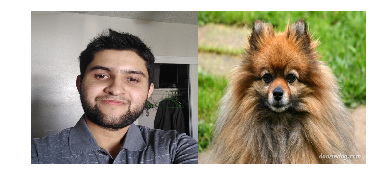

Hello human,
You look like a Pomeranian.



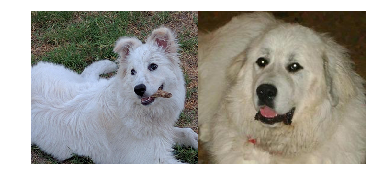

Dog breed detected: Great_pyrenees



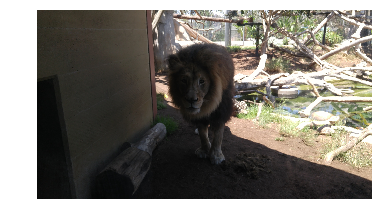

Error: No humans or dogs detected.



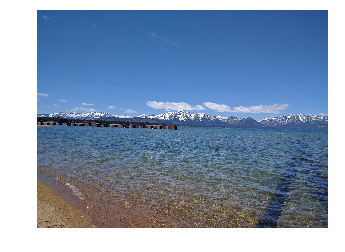

Error: No humans or dogs detected.



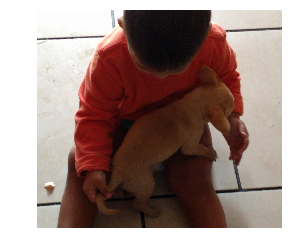

Error: No humans or dogs detected.



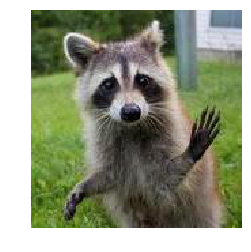

Error: No humans or dogs detected.


In [69]:
# Images
img_dir = 'images/'
images = ['jacob', 'white_dog', 'lion', 'water', 'chi', 'raccoon']

for img in images:
    print(img_predict(img_dir + img + '.jpg'))